Idee:
Bei hoher Geschwindigkeit oder in Kurven sind unsere Bilder mit den aktuellen Kameraeinstellungen sehr unscharf. Mit verschiedenen Kernels wurde angeschaut, ob man den Kontrast noch erhöhen konnte anstelle der morphologischen Operation.

Ausgangssituation:
Der Kontrast kann zwar erhöht werden, jedoch gerade bei verschwommenen Bilder entstehen mehrere Kanten, was bei den Konturensuche zu mehr Zeitauffand führt. Es ist kein positiver Effekt zu erkennen gegenüber der morphologischen Operation.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('images/test_run2/big/imageFromWeb_010.jpg')
img = img[100:300,80:400]
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hsv_h,hsv_s,hsv_v = cv2.split(hsv)
height, width = hsv_v.shape
plt.imshow(hsv_v, cmap='gray')

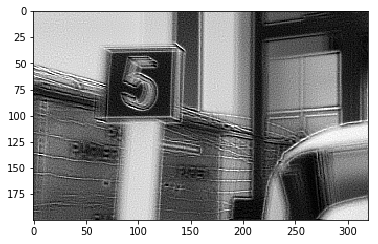

In [2]:
kernel = np.array([[1,1,1],[1,-7,1],[1,1,1]])
sharped = cv2.filter2D(hsv_v,-1,kernel)
plt.imshow(sharped, cmap='gray')

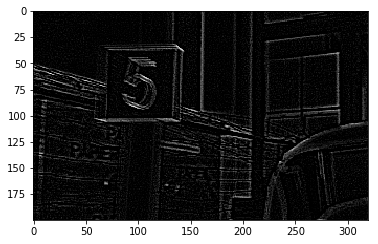

In [3]:
img_added = cv2.subtract(hsv_v,sharped)
plt.imshow(img_added, cmap='gray')

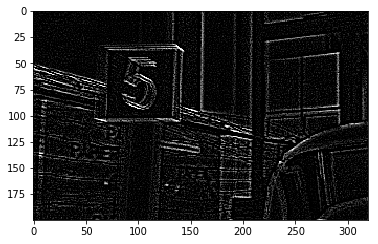

In [4]:
height, width = hsv_v.shape

imgTopHat = np.zeros((height, width, 1), np.uint8)
imgBlackHat = np.zeros((height, width, 1), np.uint8)

structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(img_added, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(img_added, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(img_added, imgTopHat)
imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

imgMaxContrast = imgGrayscalePlusTopHatMinusBlackHat
plt.imshow(imgMaxContrast, cmap='gray')

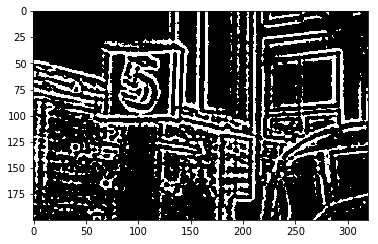

In [5]:
GAUSSIAN_SMOOTH_FILTER_SIZE = (7, 7)
ADAPTIVE_THRESH_BLOCK_SIZE = 9
ADAPTIVE_THRESH_WEIGHT = 3

imgBlurred = np.zeros((height, width, 1), np.uint8)

imgBlurred = cv2.GaussianBlur(imgMaxContrast, GAUSSIAN_SMOOTH_FILTER_SIZE, 0)
imgThresh = cv2.adaptiveThreshold(imgBlurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, ADAPTIVE_THRESH_BLOCK_SIZE, ADAPTIVE_THRESH_WEIGHT)

plt.imshow(imgThresh, cmap='gray')

146 196 rectangle 146 196 2 3
235 197 rectangle 235 195 2 5
227 193 rectangle 227 192 3 5
77 190 rectangle 76 190 3 2
234 189 rectangle 234 189 2 3
21 188 rectangle 20 188 4 2
68 185 rectangle 66 185 5 3
44 184 rectangle 42 184 5 2
1 184 rectangle 0 184 4 2
175 181 rectangle 174 178 4 9
17 178 square 17 178 2 2
184 178 rectangle 182 173 10 14
198 173 rectangle 194 172 12 5
157 165 rectangle 156 165 3 2
145 165 rectangle 144 165 3 2
239 164 rectangle 238 162 3 4
219 161 rectangle 218 161 3 2
20 161 rectangle 19 161 3 2
290 159 rectangle 290 156 3 6
250 157 rectangle 249 156 3 4
244 151 rectangle 243 151 3 2
116 151 rectangle 116 151 2 3
140 149 rectangle 139 149 3 2
224 146 rectangle 223 146 3 2
63 145 rectangle 62 145 4 3
116 145 rectangle 116 144 2 3
48 145 square 47 144 3 3
289 146 rectangle 289 143 2 8
21 144 rectangle 16 143 12 3
270 143 rectangle 268 142 7 6
79 140 square 79 140 2 2
27 135 rectangle 22 133 12 5
19 133 rectangle 18 133 3 2
134 135 rectangle 121 132 32 13
225 129 re

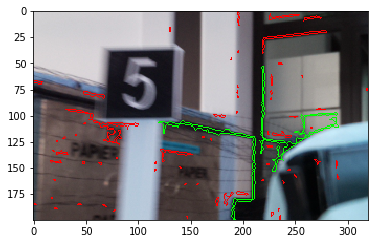

In [6]:
# After finding edges we have to find contours
# Contour is a curve of points with no gaps in the curve
# It will help us to find location of shapes

# cv2.RETR_EXTERNAL is passed to find the outermost contours (because we want to outline the shapes)
# cv2.CHAIN_APPROX_SIMPLE is removing redundant points along a line
(_, cnts, _) = cv2.findContours(imgThresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


'''
We are going to use contour approximation method to find vertices of
geometric shapes. The alogrithm  is also known as Ramer Douglas Peucker alogrithm.
In OpenCV it is implemented in cv2.approxPolyDP method.abs
detectShape() function below takes a contour as parameter and
then returns its shape
 '''


def detectShape(cnt):
    shape = 'unknown'
    # calculate perimeter using
    peri = cv2.arcLength(c, True)
    # apply contour approximation and store the result in vertices
    vertices = cv2.approxPolyDP(c, 0.04 * peri, True)

    # If the shape it triangle, it will have 3 vertices
    if len(vertices) == 3:
        shape = 'triangle'

    # if the shape has 4 vertices, it is either a square or
    # a rectangle
    elif len(vertices) == 4:
        # using the boundingRect method calculate the width and height
        # of enclosing rectange and then calculte aspect ratio

        x, y, width, height = cv2.boundingRect(vertices)
        aspectRatio = float(width) / height

        # a square will have an aspect ratio that is approximately
        # equal to one, otherwise, the shape is a rectangle
        if aspectRatio >= 0.95 and aspectRatio <= 1.05:
            shape = "square"
        else:
            shape = "rectangle"

    # if the shape is a pentagon, it will have 5 vertices
    elif len(vertices) == 5:
        shape = "pentagon"

    # otherwise, we assume the shape is a circle
    else:
        shape = "circle"

    # return the name of the shape
    return shape


# Now we will loop over every contour
# call detectShape() for it and
# write the name of shape in the center of image

# loop over the contours
for c in cnts:
    # compute the moment of contour
    M = cv2.moments(c)
    if(M['m00']!=0.0):
        # From moment we can calculte area, centroid etc
        # The center or centroid can be calculated as follows
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])

        # call detectShape for contour c
        shape = detectShape(c)
        
        if((shape == "square" or shape == "rectangle")) :
            
            x,y,w,h = cv2.boundingRect(c)
            
            print(cX, cY, shape, x,y,w,h)
            
            ratio = w/h

            # Outline the contours
            if(ratio > 0.75 and ratio < 1.25 and w > 10):
                cv2.drawContours(img, [c], -1, (0, 255, 0), 1)
                print('this is our square')
            else:
                cv2.drawContours(img, [c], -1, (255, 0, 0), 1)

            # Write the name of shape on the center of shapes
            #cv2.putText(ausschnitt_big, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            # show the output image
            plt.imshow(img)